In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# NB201
from nas_201_api import NASBench201API as API

from ntk import get_ntk_n
from linear_region_counter import Linear_Region_Collector

import scipy.stats as stats
import matplotlib.pyplot as plt

import tqdm

# custom
from custom_models import get_cell_based_tiny_net

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='../../configs/nas-benchmark/algos/RANDOM.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
# parser.add_argument("--channel", type=int, default=3, help="The number of channels.")
# parser.add_argument("--num_cells", type=int, default=1, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=0, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./results/tmp', help="Folder to save checkpoints and log.")
parser.add_argument("--arch_nas_dataset", type=str, default='../../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

36634
Namespace(arch_nas_dataset='../../NAS-Bench-201-v1_1-096897.pth', channel=16, config_path='../../configs/nas-benchmark/algos/RANDOM.config', data_path='../../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=36634, save_dir='./results/tmp', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=0)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../../NAS-Bench-201-v1_1-096897.pth
channel          : 16
config_path      : ../../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 36634
save_dir         : ./results/tmp
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 0
Python  Version  : 3.8.8 (default, Feb 24 2021, 21:46:12)  [GCC 7.3.0]
Pillow  Version  : 8.1.2
PyTorch Version  : 1.8.1
cuDNN   Version  : 8005
CUDA available   : True
CUDA GPU numbers : 1
CUDA_VISIBLE_DEVICES : 0


In [231]:
def kaiming_normal_fanin_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def kaiming_normal_fanout_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def init_model(model, method='kaiming_norm_fanin'):
    if method == 'kaiming_norm_fanin':
        model.apply(kaiming_normal_fanin_init)
    elif method == 'kaiming_norm_fanout':
        model.apply(kaiming_normal_fanout_init)
    return model

####### original
def pca_eig_diag(xloader, network, num_batch=1):
    device = torch.cuda.current_device()
    network.train()
    
    with torch.no_grad():
        feat_list = []
        for i, (inputs, targets) in enumerate(xloader):
            if num_batch > 0 and i >= num_batch: break

            inputs = inputs.cuda(device=device, non_blocking=True)
            network.zero_grad()
            inputs_ = torch.randn_like(inputs)
            _ = network(inputs_)
            feat = network.last_feature_map.detach().clone()
            b,c,h,w = feat.size()
            feat_list.append(feat.permute(0,2,3,1).contiguous().view(b*h*w,c))

        feat = torch.cat(feat_list, dim=0)
        m = feat.mean(dim=0, keepdim=True)
        feat = feat - m
        sigma = torch.mm(feat.transpose(1,0),feat) / (feat.size(0))
        u, s, v = torch.svd(sigma)
        prob_s = s / s.sum()
        score = (-prob_s)*torch.log(prob_s+1e-8)
        score = score.sum()
        
#         scores = []
#         for f in network.cell_features:
#             b,c,h,w = f.size()
#             feat = f.permute(0,2,3,1).contiguous().view(b*h*w,c)
#             m = feat.mean(dim=0, keepdim=True)
#             feat = feat - m
#             sigma = torch.mm(feat.transpose(1,0),feat) / (feat.size(0))
#             u, s, v = torch.svd(sigma)
#             prob_s = s / s.sum()
#             score = (-prob_s)*torch.log(prob_s+1e-8)
#             score = score.sum().item()
#             scores.append(score)
#         score = np.sum(np.array(scores[1:]) - np.array(scores[:-1]))
            
        torch.cuda.empty_cache()
    
    return score.item()

def grad_vanish(xloader, network, criterion, num_batch=1):
    device = torch.cuda.current_device()
    network.train()
    
    for i, (inputs, targets) in enumerate(xloader):
        if num_batch > 0 and i >= num_batch: break

        inputs = inputs.cuda(device=device, non_blocking=True)
        targets = targets.cuda(device=device, non_blocking=True)
        
        network.zero_grad()
#         inputs_ = inputs
        inputs_ = torch.randn_like(inputs)
        _, logits = network(inputs_)


################### std
#         cell_features = network.cell_features
    
#         loss = criterion(logits, targets)
#         loss.backward()

#         scores = []
#         for i in reversed(range(1, len(cell_features))):
#             f_out = cell_features[i]
#             f_in = cell_features[i-1]

#             if f_out.size() == f_in.size():
#                 if torch.all(f_in.grad == f_out.grad) or torch.all(f_in == f_out):
#                     scores.append(-1)
#             else:
#                 s = f_in.grad.view(-1).std() / (f_out.grad.view(-1).std()+1e-6)
# #                 scores.append(s.item())
#                 scores.append(-((1-s.item())**2))
#         score = np.mean(scores)
################### weight grad
#         loss = criterion(logits, targets)
#         loss.backward()

# #         g = torch.randn_like(network.last_feature_map)
# #         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
# #         network.last_feature_map.backward(g)
#         w_g = network.stem[0].weight.grad
#         c_out,c_in,kh,kw = w_g.size()
#         score = w_g.view(c_out,-1).norm(dim=1).mean()
################### using a CE loss
#         loss = criterion(logits, targets)
#         loss.backward()
#         cell_features = network.cell_features

#         scores = []
#         for i in reversed(range(1, len(cell_features))):
#             f_out = cell_features[i]
#             f_in = cell_features[i-1]
        
#             s = f_in.grad.norm(dim=(1)).mean() / (f_out.grad.norm(dim=(1)).mean()+1e-6)
# #             s = f_in.grad.norm() / (f_out.grad.norm()+1e-6)
# #             print(s)
# #             scores.append(s.item())
#             scores.append(-np.abs(1-s.item()))
#         score = np.mean(scores)  
################### # feature vector norm 0.42
#         g = torch.randn_like(network.last_feature_map)
#         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
#         network.last_feature_map.backward(g)
        
#         s_grad_norm = network.first_feature_map.grad.norm(dim=(1))
#         score = s_grad_norm.mean()
################### traverse all cell features
#         cell_features = network.cell_features
#         f_last = cell_features[-1]
#         g = torch.randn_like(f_last)
#         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
#         f_last.backward(g)
        
#         scores = []
#         for i in reversed(range(1, len(cell_features))):
# #         for i in reversed(range(1, 5)):
#             f_out = cell_features[i]
#             f_in = cell_features[i-1]
        
#             s = f_in.grad.norm(dim=(1)).mean() / (f_out.grad.norm(dim=(1)).mean()+1e-6)
# #             scores.append(s.item())
#             scores.append(-np.abs(1-s.item()))
#         score = np.mean(scores)
################### channel norm
#         g = torch.randn_like(network.last_feature_map)
#         g = g / (g.norm(dim=(2,3),keepdim=True)+1e-6)
#         network.last_feature_map.backward(g)
        
#         s_grad_norm = network.first_feature_map.grad.norm(dim=(2,3))
#         score = s_grad_norm.mean()
################### entire norm
#         g = torch.randn_like(network.last_feature_map)
#         g = g / (g.norm()+1e-6)
#         network.last_feature_map.backward(g)
        
#         s_grad_norm = network.first_feature_map.grad.norm()
#         score = s_grad_norm
################### # batch-wise norm
#         g = torch.randn_like(network.last_feature_map)
#         b,c,h,w = g.size()
#         g = g.view(b, -1)
#         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
#         g = g.view(b,c,h,w)
#         network.last_feature_map.backward(g)
        
#         g = network.first_feature_map.grad
#         b,c,h,w = g.size()
#         g = g.view(b, -1)
#         s_grad_norm = g.norm(dim=(1))
#         score = s_grad_norm.mean()
################### traverse cell features in a stage
        cell_features = network.cell_features
        f_last = cell_features[-1]
        g = torch.randn_like(f_last)
        g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
        f_last.backward(g)
        
        scores = []
        for i in reversed(range(1, len(cell_features))):
            f_out = cell_features[i]
            f_in = cell_features[i-1]
#         for i in range(1, 5):
#             f_out = cell_features[-i]
#             f_in = cell_features[-i-1]
            
            s1 = f_in.grad.norm(dim=(1)).mean() / (f_out.grad.norm(dim=(1)).mean()+1e-6)
            s2 = f_out.norm(dim=(1)).mean() / (f_in.norm(dim=(1)).mean()+1e-6)
#             s1 = f_in.grad.view(-1).std() / (f_out.grad.view(-1).std()+1e-6)
#             s2 = f_out.view(-1).std() / (f_in.view(-1).std()+1e-6)
#             print(s1, s2)
            if (f_out.size() == f_in.size()) and (torch.all(f_in.grad == f_out.grad) or torch.all(f_in == f_out)):
                print("detected")
                scores.append(-1)
            else:
#                 s = -torch.abs(s1-1)*torch.abs(s2-1)
#                 scores.append(s.item())
                scores.append((-torch.abs(s2-1)).item())
#             scores.append(-np.abs(1-s.item()))
        score = np.mean(scores)

    torch.cuda.empty_cache()
    
    return score.item()

def search_find_best(xloader, network, criterion, lrc_model, n_samples):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    network.train()
    archs, pca_scores, grad_scores, ntk_scores, lr_scores = [], [], [], [], []
    
    for i in tqdm.tqdm(range(n_samples)):
        # random sampling
        arch = network.random_genotype(True)
    
        pca_score_tmp, grad_score_tmp, ntk_score_tmp, lr_score_tmp = [], [], [], []
        pca_time, grad_time, ntk_time, lr_time = [], [], [], []
        pca_mem, grad_mem, ntk_mem, lr_mem = [], [], [], []
        
        for _ in range(1):
            init_model(network)
            
            # pca score
            start.record()
            torch.cuda.reset_peak_memory_stats()
            score = pca_eig_diag(xloader, network)
            pca_score_tmp.append(score)
            end.record()
            torch.cuda.synchronize()
            pca_time.append(start.elapsed_time(end))
            pca_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()
            
            # grad score
            start.record()
            torch.cuda.reset_peak_memory_stats()
            score = grad_vanish(xloader, network, criterion)
            grad_score_tmp.append(score)
            end.record()
            torch.cuda.synchronize()
            grad_time.append(start.elapsed_time(end))
            grad_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()
            
#             # ntk score        
#             start.record()
#             torch.cuda.reset_peak_memory_stats()
#             score = -get_ntk_n(xloader, [network], recalbn=0, train_mode=True, num_batch=1)[0]
#             end.record()
#             torch.cuda.synchronize()
#             ntk_time.append(start.elapsed_time(end))
#             ntk_mem.append(torch.cuda.max_memory_reserved())
#             torch.cuda.empty_cache()
#             ntk_score_tmp.append(score)
            
#             # lr score
#             start.record()
#             torch.cuda.reset_peak_memory_stats()
#             lrc_model.reinit(models=[network], seed=xargs.rand_seed)
#             score = lrc_model.forward_batch_sample()
#             end.record()
#             torch.cuda.synchronize()
#             lr_time.append(start.elapsed_time(end))
#             lr_mem.append(torch.cuda.max_memory_reserved())
#             lr_score_tmp.append(score)
#             lrc_model.clear()
        
#         print(pca_score_tmp)
#         print(np.mean(pca_score_tmp))
#         print(np.std(pca_score_tmp))
        
#         print(ntk_score_tmp)
#         print(np.mean(ntk_score_tmp))
#         print(np.std(ntk_score_tmp))
        
        archs.append(arch)
        pca_scores.append(np.mean(pca_score_tmp))
        grad_scores.append(np.mean(grad_score_tmp))
        ntk_scores.append(np.mean(ntk_score_tmp))
        lr_scores.append(np.mean(lr_score_tmp))
        
    pca_scores = np.nan_to_num(np.array(pca_scores), nan=-np.inf)
    grad_scores = np.nan_to_num(np.array(grad_scores), nan=-np.inf)
    ntk_scores = np.nan_to_num(np.array(ntk_scores), nan=-np.inf)
    lr_scores = np.nan_to_num(np.array(lr_scores), nan=-np.inf)

#         print(arch)
#         print("-----------------")
#         print("PCA: {:.5f} ms".format(np.mean(pca_time)))
#         print("Grad: {:.5f} ms".format(np.mean(grad_time)))
#         print("NTK: {:.5f} ms".format(np.mean(ntk_time)))
#         print("LR: {:.5f} ms".format(np.mean(lr_time)))
#         print("-----------------")
#         print("PCA: {:.5f} GB".format(np.mean(pca_mem)/1e9))
#         print("Grad: {:.5f} GB".format(np.mean(grad_mem)/1e9))
#         print("NTK: {:.5f} GB".format(np.mean(ntk_mem)/1e9))
#         print("LR: {:.5f} GB".format(np.mean(lr_mem)/1e9))
#         print("-----------------\n")
        
    return archs, pca_scores, grad_scores, ntk_scores, lr_scores

# Main

In [5]:
## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))


## model
search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

_, _, criterion = get_optim_scheduler(search_model.parameters(), config)
criterion = criterion.cuda()

if "api" not in vars():
    if xargs.arch_nas_dataset is None:
        api = None
    else:
        api = API(xargs.arch_nas_dataset)
    logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
# network = torch.nn.DataParallel(search_model).cuda()
network = search_model.cuda()

## LRC
if "lrc_model" not in vars():
    lrc_model = Linear_Region_Collector(input_size=(333, 3, 3, 3), sample_batch=3, dataset=xargs.dataset, data_path=xargs.data_path, seed=xargs.rand_seed)


## misc
if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
../../configs/nas-benchmark/algos/RANDOM.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
try to create the NAS-Bench-201 api from ../../NAS-Bench-201-v1_1-096897.pth
[2023-02-06 04:13:24] create API = NASBench201API(15625/15625 architectures, file=NAS-Bench-201-v1_1-096897.pth) done
Files already downloaded and verified
Files already downloaded and verified
=> do not find the last-info file : re

In [237]:
n_samples = 1000

archs, pca_scores, grad_scores, ntk_scores, lr_scores = search_find_best(train_loader, network, criterion, lrc_model, n_samples)

  1%|          | 8/1000 [00:03<09:20,  1.77it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


  2%|▏         | 15/1000 [00:04<04:05,  4.01it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


  2%|▏         | 16/1000 [00:04<03:56,  4.17it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


  6%|▌         | 58/1000 [00:19<03:58,  3.95it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 10%|█         | 102/1000 [00:33<03:22,  4.42it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 12%|█▏        | 116/1000 [00:39<05:51,  2.51it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 12%|█▏        | 120/1000 [00:40<03:54,  3.76it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 12%|█▏        | 122/1000 [00:40<03:33,  4.11it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 15%|█▌        | 152/1000 [00:51<03:53,  3.64it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 17%|█▋        | 170/1000 [00:57<04:43,  2.93it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 22%|██▏       | 216/1000 [01:13<03:31,  3.70it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 26%|██▌       | 260/1000 [01:27<03:08,  3.92it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 28%|██▊       | 281/1000 [01:35<03:22,  3.55it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 30%|███       | 303/1000 [01:42<02:59,  3.88it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 31%|███       | 309/1000 [01:45<03:57,  2.91it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 31%|███▏      | 313/1000 [01:46<02:56,  3.90it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 31%|███▏      | 314/1000 [01:46<02:45,  4.14it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 34%|███▎      | 335/1000 [01:53<02:51,  3.87it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 39%|███▊      | 386/1000 [02:11<02:47,  3.66it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 43%|████▎     | 432/1000 [02:26<02:13,  4.26it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 44%|████▍     | 442/1000 [02:30<02:11,  4.25it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 52%|█████▏    | 522/1000 [02:55<01:48,  4.40it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 52%|█████▎    | 525/1000 [02:56<01:24,  5.64it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 54%|█████▍    | 542/1000 [03:00<02:02,  3.73it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 56%|█████▌    | 555/1000 [03:02<01:29,  5.00it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 57%|█████▋    | 566/1000 [03:05<01:22,  5.26it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 57%|█████▋    | 572/1000 [03:05<00:58,  7.29it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 59%|█████▉    | 589/1000 [03:09<01:05,  6.24it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 62%|██████▏   | 617/1000 [03:16<01:44,  3.68it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 63%|██████▎   | 632/1000 [03:19<01:00,  6.06it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 65%|██████▍   | 648/1000 [03:23<01:55,  3.06it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 68%|██████▊   | 675/1000 [03:28<00:44,  7.33it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 70%|██████▉   | 699/1000 [03:33<00:41,  7.26it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 71%|███████   | 707/1000 [03:35<00:45,  6.40it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 72%|███████▏  | 717/1000 [03:38<00:48,  5.82it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 74%|███████▎  | 737/1000 [03:42<00:47,  5.56it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 74%|███████▍  | 739/1000 [03:43<00:40,  6.44it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 75%|███████▍  | 746/1000 [03:45<01:17,  3.30it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 75%|███████▍  | 747/1000 [03:45<01:09,  3.63it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 78%|███████▊  | 777/1000 [03:56<01:29,  2.48it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 79%|███████▉  | 793/1000 [04:01<00:55,  3.74it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 83%|████████▎ | 830/1000 [04:11<00:46,  3.69it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 84%|████████▍ | 844/1000 [04:13<00:28,  5.43it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 85%|████████▍ | 849/1000 [04:14<00:20,  7.28it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 85%|████████▌ | 853/1000 [04:16<00:34,  4.31it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 87%|████████▋ | 870/1000 [04:19<00:18,  7.07it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 89%|████████▉ | 892/1000 [04:24<00:15,  7.18it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 97%|█████████▋| 973/1000 [04:42<00:04,  6.05it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


 99%|█████████▉| 990/1000 [04:46<00:03,  3.18it/s]

detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected
detected


100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]


In [238]:
%%capture
def get_results_from_api(api, arch):
    # print(api.query_by_arch(arch, "200"))
    index = api.query_index_by_arch(arch)
#     results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
#     results = api.query_by_index(index, 'cifar100', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    results = api.query_by_index(index, 'cifar10', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    
    # valid acc
    acc = 0
    for seed, result in results.items():
#         acc = acc + result.get_eval('valid')['accuracy']
#         acc = acc + result.get_eval('x-test')['accuracy']
        acc = acc + result.get_eval('ori-test')['accuracy']
    acc = acc / len(results)
    
    result = list(results.values())[0]
    
    return acc, result.flop, result.params

api_valid_accs, api_flops, api_params = [], [], []
for a in archs:
    valid_acc, flops, params = get_results_from_api(api, a)
    api_valid_accs.append(valid_acc)
    api_flops.append(flops)
    api_params.append(params)

In [205]:
# sorted_indices = np.argsort(api_valid_accs)
# sorted_indices = np.argsort(pca_scores)

# for a, s, acc in zip(np.array(archs)[sorted_indices], np.array(pca_scores)[sorted_indices], np.array(api_valid_accs)[sorted_indices]):
#     print(a)
#     print("{:.3f}".format(acc), '\t', s)

[(('skip_connect', 0),) (('avg_pool_3x3', 0), ('none', 1))
 (('skip_connect', 0), ('nor_conv_3x3', 1), ('avg_pool_3x3', 2))]
87.617 	 -1.172324538230896
[(('nor_conv_1x1', 0),) (('avg_pool_3x3', 0), ('avg_pool_3x3', 1))
 (('skip_connect', 0), ('avg_pool_3x3', 1), ('avg_pool_3x3', 2))]
85.027 	 -1.1624749898910522
[(('skip_connect', 0),) (('avg_pool_3x3', 0), ('nor_conv_3x3', 1))
 (('nor_conv_3x3', 0), ('none', 1), ('avg_pool_3x3', 2))]
89.813 	 0.2494206428527832
[(('skip_connect', 0),) (('avg_pool_3x3', 0), ('nor_conv_1x1', 1))
 (('avg_pool_3x3', 0), ('nor_conv_1x1', 1), ('nor_conv_1x1', 2))]
89.187 	 0.2967958450317383
[(('none', 0),) (('skip_connect', 0), ('nor_conv_1x1', 1))
 (('avg_pool_3x3', 0), ('avg_pool_3x3', 1), ('nor_conv_3x3', 2))]
91.587 	 0.376969575881958
[(('none', 0),) (('nor_conv_3x3', 0), ('skip_connect', 1))
 (('avg_pool_3x3', 0), ('skip_connect', 1), ('skip_connect', 2))]
91.213 	 0.49945592880249023
[(('none', 0),) (('nor_conv_1x1', 0), ('skip_connect', 1))
 (('av

<ipython-input-205-4a61ba075066>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for a, s, acc in zip(np.array(archs)[sorted_indices], np.array(pca_scores)[sorted_indices], np.array(api_valid_accs)[sorted_indices]):


# Analysis

RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|) with ntk_score=-inf, lr_score=-inf
153.27297 1.073466



Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
|nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=873
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=20.97 ms.
cifar10-valid  train : [loss = 0.002, top1 = 99.98%], valid : [loss = 0.510, top1 = 89.92%]
cifar10        FLOP=153.27 M, Params=1.073 MB, latency=20.97 ms.
cifar10        train : [loss = 0.003, top1 = 99.96

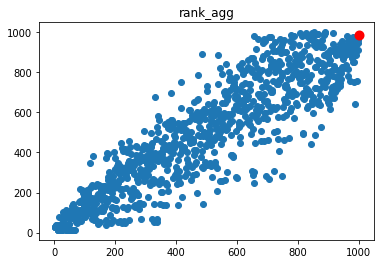

0.7250762491729562 4.88646927227123e-258


In [246]:
rank_pca, rank_grad, rank_ntk, rank_lr, rank_flops, rank_params = \
stats.rankdata(pca_scores), stats.rankdata(grad_scores), stats.rankdata(ntk_scores), stats.rankdata(lr_scores), stats.rankdata(api_flops), stats.rankdata(api_params)

###
# tmp = -np.abs(1.5-np.array(grad_scores))
# rank_grad = stats.rankdata(tmp)
###

l = len(api_valid_accs)
rank_agg = rank_pca + rank_grad + rank_params
rank_agg = np.log(rank_pca/l) + np.log(rank_grad/l) + np.log(rank_params/l)
# rank_agg = np.log(rank_pca/l) + np.log(rank_grad/l) + np.log(rank_ntk/l) + np.log(rank_lr/l) + np.log(rank_params/l)

best_idx = np.argmax(rank_agg)
best_arch, best_ntk_score, best_lr_score, flops, params = archs[best_idx], ntk_scores[best_idx], lr_scores[best_idx], api_flops[best_idx], api_params[best_idx]

print("RANDOM-NAS finds the best one : {:} with ntk_score={:}, lr_score={:}".format(best_arch, best_ntk_score, best_lr_score))
print(flops, params)
print("\n\n")
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

x = stats.rankdata(rank_agg)
# x = np.array(grad_scores)
# plt.xlim([-0.2,0])
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("rank_agg")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

In [117]:
sorted_indices = np.argsort(api_valid_accs)
sorted_indices = np.argsort(grad_scores)

for a, s, acc in zip(np.array(archs)[sorted_indices], np.array(grad_scores)[sorted_indices], np.array(api_valid_accs)[sorted_indices]):
    print(a)
    print("{:.3f}".format(acc), '\t', s)

[(('skip_connect', 0),) (('skip_connect', 0), ('none', 1))
 (('skip_connect', 0), ('avg_pool_3x3', 1), ('skip_connect', 2))]
68.143 	 -2.522116430103779
[(('skip_connect', 0),) (('none', 0), ('avg_pool_3x3', 1))
 (('avg_pool_3x3', 0), ('avg_pool_3x3', 1), ('skip_connect', 2))]
58.777 	 -2.492975982837379
[(('skip_connect', 0),) (('skip_connect', 0), ('skip_connect', 1))
 (('nor_conv_3x3', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))]
79.833 	 -2.4226902313530445
[(('skip_connect', 0),) (('skip_connect', 0), ('skip_connect', 1))
 (('nor_conv_1x1', 0), ('avg_pool_3x3', 1), ('skip_connect', 2))]
79.330 	 -2.41764610260725
[(('avg_pool_3x3', 0),) (('nor_conv_3x3', 0), ('skip_connect', 1))
 (('avg_pool_3x3', 0), ('none', 1), ('none', 2))]
75.830 	 -2.0753073519445024
[(('none', 0),) (('avg_pool_3x3', 0), ('nor_conv_3x3', 1))
 (('avg_pool_3x3', 0), ('nor_conv_3x3', 1), ('none', 2))]
75.615 	 -1.6011881113226991
[(('none', 0),) (('none', 0), ('nor_conv_1x1', 1))
 (('none', 0), ('none', 1), (

<ipython-input-117-afcd6e867ef8>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for a, s, acc in zip(np.array(archs)[sorted_indices], np.array(grad_scores)[sorted_indices], np.array(api_valid_accs)[sorted_indices]):


In [10]:
# fp_results = torch.load("./c3n1_1000samples.pth")
# archs = fp_results['archs']
# fp_ntk_scores = fp_results['ntk_scores']
# fp_lr_scores = fp_results['lr_scores']
# api_valid_accs = fp_results['api_valid_accs']
# api_flops = fp_results['api_flops']
# api_params = fp_results['api_params']

# torch.save({"archs":archs,
#             "ntk_scores":ntk_scores,
#             "pca_scores":pca_scores,
#             "lr_scores":lr_scores,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./c3n5_1000samples_32_8_4_2.pth")

# torch.save({"archs":archs,
#             "fp_ntk_scores":fp_ntk_scores,
#             "fp_lr_scores":fp_lr_scores,
#             "q_ntk_scores":q_ntk_scores,
#             "q_lr_scores":q_lr_scores,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./c3n5_1000samples_1bit.pth")

# trained_results = torch.load("./c3n5_1000samples_4bit.pth")
# archs = trained_results['archs']
# fp_ntk_scores = trained_results['fp_ntk_scores']
# fp_lr_scores = trained_results['fp_lr_scores']
# q_ntk_scores = trained_results['q_ntk_scores']
# q_lr_scores = trained_results['q_lr_scores']
# api_valid_accs = trained_results['api_valid_accs']
# api_flops = trained_results['api_flops']
# api_params = trained_results['api_params']